In [1]:
import json
import sympy
import numpy
from mira.metamodel import *
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model

In [2]:
E_PSII = Concept(name='E_PSII')
Q = Concept(name='Q')
P_NPQ = Concept(name='P_NPQ')
NADPp = Concept(name='NADPp')
NADPH = Concept(name='NADPH')
R = Concept(name='R')

concepts = [E_PSII, Q, P_NPQ, NADPp, NADPH, R]

In [3]:
inits = {
    'E_PSII': 0.0,
    'Q': 0.0,
    'P_NPQ': 0.0,
    'NADPp': 5.0,
    'NADPH': 5.0,
    'R': 0.001,
}

params = {
    'PAR': 520,
    'alpha': 0.78,
    'c_in': 0.23,
    'E_PSII_star': 157.56,
    'v_ETR': 0.78,
    'v_d': 0.08,
    'Q_star': 0.07,
    'v_NPQ': 70.58,
    'v_p': 0.07,
    'v_C': 11.75,
    'eta_NADPH': 5.07,
    'eta_NADPp': 0.89,
    'v_R': 8.9e-4,
    'd': 8.40,
    'c_y': -4
}

In [4]:
symbols = {c.name: sympy.Symbol(c.name) for c in concepts}
symbols.update({k: sympy.Symbol(k) for k in params})

In [5]:
energy_input = safe_parse_expr('alpha*c_in*PAR*(1-E_PSII/E_PSII_star)', local_dict=symbols)
ETR = safe_parse_expr('v_ETR*E_PSII*NADPp', local_dict=symbols)
CEF = energy_input - ETR
energy_dissipation = safe_parse_expr('v_d*E_PSII*P_NPQ*(1-Q/Q_star)', local_dict=symbols)

templates = [
    NaturalProduction(
        outcome=E_PSII,
        rate_law=energy_input),
    ControlledDegradation(
        subject=E_PSII,
        controller=NADPp).with_mass_action_rate_law('v_ETR'),
    GroupedControlledDegradation(
        subject=E_PSII,
        controllers=[P_NPQ, Q],
        rate_law=energy_dissipation),
    GroupedControlledProduction(
        outcome=Q,
        controllers=[P_NPQ, E_PSII],
        rate_law=energy_dissipation),
    NaturalDegradation(
        subject=Q).with_mass_action_rate_law('v_NPQ'),
    NaturalProduction(
        outcome=P_NPQ,
        rate_law=sympy.Piecewise((safe_parse_expr('v_p*(1-P_NPQ)', local_dict=symbols),
                                  CEF > sympy.Symbol('c_y')),
                                 (0, True))),
    NaturalConversion(
        outcome=NADPH,
        subject=NADPp,
        rate_law=ETR*sympy.Symbol('eta_NADPp')),
    ControlledConversion(
        subject=NADPH,
        outcome=NADPp,
        controller=R,
        rate_law=safe_parse_expr('v_C*R*NADPH*eta_NADPH', local_dict=symbols)),
    NaturalProduction(
        outcome=R,
        rate_law=safe_parse_expr('v_R*(1-R)*min(d, NADPH/NADPp)', local_dict=symbols))
]

observables = {
    'ETR': Observable(name='ETR', expression=ETR),
    'NPQ': Observable(name='NPQ', expression=sympy.Symbol('v_NPQ') * sympy.Symbol('Q')),
    'A': Observable(name='A', expression=sympy.Symbol('v_C')*sympy.Symbol('R')*sympy.Symbol('NADPH'))
}

In [6]:
parameters = {p: Parameter(name=p, value=v) for p, v in params.items()}
initials = {i: Initial(concept=Concept(name=i), expression=v) for i, v in inits.items()}

In [7]:
tm = TemplateModel(templates=templates,
                   parameters=parameters,
                   initials=initials,
                   observables=observables)

In [8]:
om = OdeModel(Model(tm), initialized=True)

In [9]:
om.kinetics

Matrix([
[          (1 - y[0, 0]/p[3, 0])*p[4, 0]*p[5, 0]*p[6, 0] - (1 - y[3, 0]/p[7, 0])*p[8, 0]*y[0, 0]*y[2, 0] - p[0, 0]*y[0, 0]*y[1, 0]],
[                                                             -p[0, 0]*p[11, 0]*y[0, 0]*y[1, 0] + p[2, 0]*p[12, 0]*y[4, 0]*y[5, 0]],
[Piecewise(((1 - y[2, 0])*p[10, 0], p[9, 0] < (1 - y[0, 0]/p[3, 0])*p[4, 0]*p[5, 0]*p[6, 0] - p[0, 0]*y[0, 0]*y[1, 0]), (0, True))],
[                                                                  (1 - y[3, 0]/p[7, 0])*p[8, 0]*y[0, 0]*y[2, 0] - p[1, 0]*y[3, 0]],
[                                                              p[0, 0]*p[11, 0]*y[0, 0]*y[1, 0] - p[2, 0]*p[12, 0]*y[4, 0]*y[5, 0]],
[                                                                            (1 - y[5, 0])*p[14, 0]*Min(y[4, 0]/y[1, 0], p[13, 0])]])

In [10]:
om.get_interpretable_kinetics()

Matrix([
[            -E_PSII*NADPp*v_ETR - E_PSII*P_NPQ*v_d*(-Q/Q_star + 1) + PAR*alpha*c_in*(-E_PSII/E_PSII_star + 1)],
[                                                        -E_PSII*NADPp*eta_NADPp*v_ETR + NADPH*R*eta_NADPH*v_C],
[Piecewise((v_p*(1 - P_NPQ), c_y < -E_PSII*NADPp*v_ETR + PAR*alpha*c_in*(-E_PSII/E_PSII_star + 1)), (0, True))],
[                                                                   E_PSII*P_NPQ*v_d*(-Q/Q_star + 1) - Q*v_NPQ],
[                                                         E_PSII*NADPp*eta_NADPp*v_ETR - NADPH*R*eta_NADPH*v_C],
[                                                                              v_R*(1 - R)*Min(d, NADPH/NADPp)]])

In [11]:
om.vmap, om.observable_map

({'E_PSII': 0, 'NADPp': 1, 'P_NPQ': 2, 'Q': 3, 'NADPH': 4, 'R': 5},
 {'ETR': 0, 'NPQ': 1, 'A': 2})

In [12]:
ts = numpy.linspace(0,60,1000)
res = simulate_ode_model(om, times=ts, with_observables=True)

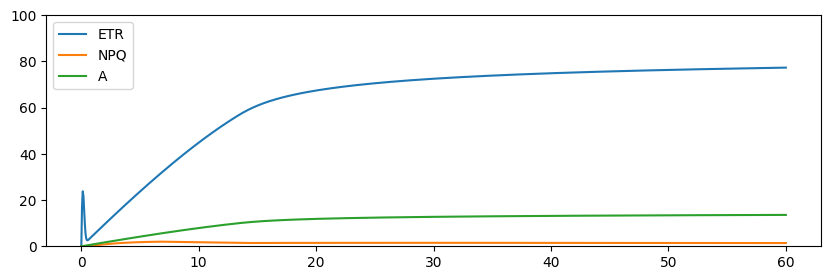

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(ts, res[:, 6:], label=list(om.observable_map.keys()))
plt.ylim([0, 100])
plt.legend()

In [14]:
pj = template_model_to_petrinet_json(tm)
with open('climate_scenario5_petri.json', 'w') as fh:
    json.dump(pj, fh, indent=1)